In [4]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

In [5]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_current_members_of_the_United_States_House_of_Representatives'
response = requests.get(wiki_url)
soup = BeautifulSoup(response.text,"lxml")

house_of_reps_text = soup.find('table',attrs={'class':"wikitable sortable plainrowheaders", 'id': "votingmembers"})

In [6]:
representatives = pd.read_html(str(house_of_reps_text))[0]
representatives = representatives.drop(['Party'], axis=1)
representatives = representatives.rename(columns={'Party.1': 'Party', 'Born[4]': 'Age'})
print(representatives.columns)

Index(['District', 'Member', 'Party', 'Prior experience', 'Education',
       'Assumed office', 'Residence', 'Age'],
      dtype='object')


In [7]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_current_United_States_senators?fbclid=IwAR3fwBqo12plcIm741lp9eP2ALJ4G49Ntch2P9_Dxg8cOmiQKODTrPluMT8'
response = requests.get(wiki_url)
soup = BeautifulSoup(response.text,"lxml")

senators_text = soup.find('table',attrs={'class':"wikitable sortable", 'id': "senators"})
senators = pd.read_html(str(senators_text))[0]
senators = senators.drop(['Party', 'Portrait'], axis=1)
senators = senators.rename(columns={'Party.1': 'Party', 'Residence[5]': 'Residence', 'Born': 'Age'})

# save to csv


In [8]:
# Save to csv 
representatives.to_csv('representatives.csv', index=False)
senators.to_csv('senators.csv', index=False)

In [9]:
import pandas as pd
senators= pd.read_csv('senators.csv')
representatives = pd.read_csv('representatives.csv')

In [10]:
#print(senators.sample(1))
print(representatives.sample(1))

       District       Member       Party Prior experience  \
226  Missouri 4  Mark Alford  Republican       Journalist   

                              Education Assumed office       Residence  \
226  University of Texas at Austin (BA)           2023  Lake Winnebago   

          Age  
226  (age 60)  


In [11]:
senators_names = senators['Senator'].tolist()

In [12]:
house_names = representatives['Member'].tolist()

In [13]:
import os
def get_page_content(pol_name):
    params = {
        "action": "query",
        "prop": "extracts",
        "exlimit":"1",
        "explaintext": "1",
        "format": "json",
        "titles": pol_name  
    }
    baseurl = "https://en.wikipedia.org/w/api.php?"
    # requests version
    wikitext = requests.get(baseurl, params=params)
    wikijson = wikitext.json()

    # get page id
    pageid = list(wikijson['query']['pages'].keys())[0]
    #wikitext = wikijson['query']['pages'][pageid]['revisions'][0]['*']
    wikitext = wikijson['query']['pages'][pageid]['extract']
    # use regex to count words in wikitext

    return wikitext

if not os.path.isdir('usa_data/senate'):
    os.mkdir('usa_data/senate')

if not os.path.isdir('usa_data/house'):
    os.mkdir('usa_data/house')

In [14]:
import re
import requests
import string

for name in senators_names:
    wikitext = get_page_content(name)
    with open('usa_data/senate/{}.txt'.format(name), 'w') as f:
        f.write(wikitext)


for name in house_names:
    wikitext = get_page_content(name)
    if name == 'Jerry Carl':
        print(wikitext)
    name = re.sub(r'[".?"]','',name)
    with open('usa_data/house/{}.txt'.format(name), 'w') as f:
        f.write(wikitext)

Jerry Lee Carl Jr. (born June 17, 1958) is an American politician and businessman serving as the U.S. representative for Alabama's 1st congressional district since 2021. The district is based in Mobile, and includes all of the state's share of the Gulf Coast. A Republican, Carl served as a member of the Mobile County Commission from 2012 to 2020, the last two years as president of the commission.
In 2019, Carl announced his candidacy for the House seat being vacated by incumbent Republican Bradley Byrne. He defeated former state senator Bill Hightower in a runoff for the Republican nomination and Democrat James Averhart in the general election.


== Early life and education ==
A native of Mobile, Alabama, Carl graduated from Sylacauga High School in 1977. He attended Lake City Community College (now Florida Gateway College) for a time, but left to move back to Mobile and start his first business.


== Career ==
After leaving community college, Carl worked for Alabama Power. He then wor

In [22]:
def getLinks(rapper_name):
    params = {
    "action": "query",
    "prop": "revisions",
    "rvprop": "content",
    "format": "json",
    "titles": rapper_name
    
    }
    baseurl = "https://en.wikipedia.org/w/api.php?"
    # requests version
    wikitext = requests.get(baseurl, params=params)
    wikijson = wikitext.json()


    pageid = list(wikijson['query']['pages'].keys())[0]
    wikitext = wikijson['query']['pages'][pageid]['revisions'][0]['*']
    links = re.findall(r'\[\[(.*?)\]\]', wikitext)
    links = [link.split('|')[0] for link in links]
    links = [link for link in links if link in senators_names or link in house_names]

    # keep only unique links
    links = list(set(links))
    
    return links

In [27]:
house_links = dict()
senate_links = dict()

counter = 0
def getPairs(dict1,Names):
    for pol in Names:
        dict1[pol] = []
        links = getLinks(pol)
        for link in links:
            if link in senators_names or link in house_names:
                dict1[pol].append(link)

getPairs(house_links,house_names)
getPairs(senate_links,senators_names)

UnboundLocalError: local variable 'counter' referenced before assignment

In [24]:
# save house names to json
import json

with open('usa_data/house_links.json', 'w') as f:
    json.dump(house_links, f)

with open('usa_data/senate_links.json', 'w') as f:
    json.dump(senate_links, f)

In [26]:
all_links = {**house_links, **senate_links}
print(len(all_links))   

534


In [ ]:
house_links = {}

for name in house_names:
    links = []
    with open('usa_data/house/{}.txt'.format(name), 'r') as f:
        text = f.read()

    links = re.findall(r'\[\[(.*?)\]\]', text)
    links = [link.split('|')[0] for link in links]
    links = [link for link in links if link in house_names or link in senators_names]
    house_links[name] = []
    house_links[name].append(links)

senate_links = {}

for name in senators_names:
    links = []
    with open('usa_data/senate/{}.txt'.format(name), 'r') as f:
        text = f.read()

    links = re.findall(r'\[\[(.*?)\]\]', text)
    links = [link.split('|')[0] for link in links]
    links = [link for link in links if link in house_names or link in senators_names]
    senate_links[name] = []
    senate_links[name].append(links)


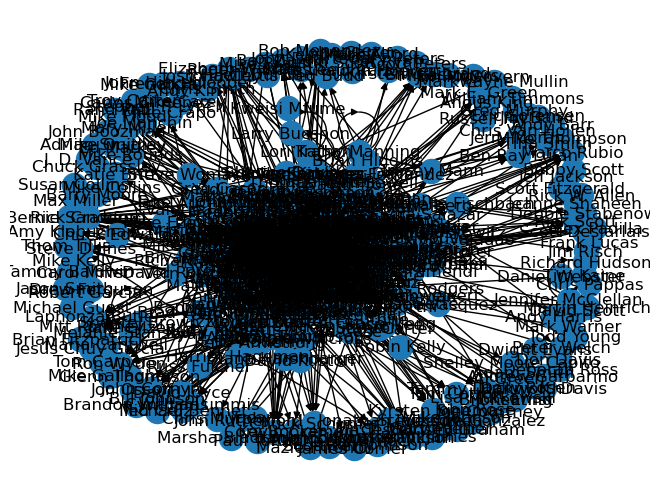

In [ ]:
import networkx as nx

G = nx.DiGraph(house_links)

nx.draw(G)


In [ ]:
# create csv with name and house or senate
all_list = []

# delete file if exists
if os.path.exists('usa_data/all_list.csv'):
    os.remove('usa_data/all_list.csv')

for name in house_names:
    with open('usa_data/all_list.csv', 'a') as f:
        f.write(str(name + "," + "house"+ "\n"))
        f.close()


for name in senators_names:
    with open('usa_data/all_list.csv', 'a') as f:
        f.write(str(name + "," + "senate"+ "\n"))
        f.close()
